In [1]:
#     # compute connected components
#     connectivity = 8
#     output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)

#     # unpack output
#     num_labels = output[0]
#     labels = output[1]
#     stats = output[2]
#     centroids = output[3]

#     # get max component label
#     area = stats[:,-1]
#     area = area[1:]
#     max_label = np.argmax(area) + 1

#     # mask out 
#     mask = np.array(labels, dtype=np.uint8)
#     mask[labels != max_label] = 0
#     mask[labels == max_label] = 255
    

In [155]:
import matplotlib.pyplot as plt
import cv2 
from skimage.filters import threshold_minimum
import scipy
import numpy as np
import matplotlib.pyplot as plt

# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html

def hole_filler(input_image):
    # dialate and erode
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(input_image, kernel, iterations=15)
    
    # fill in holes
    des = cv2.bitwise_not(mask)

    contour,hier = cv2.findContours(mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        cv2.drawContours(mask,[cnt],0,255,-1)
        
    # erode hole-free mask
    # mask = cv2.erode(mask, kernel, iterations=10)

    # smooth mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=5)
    
    return mask

def compute_convex_hull(input_mask):
    # compute contours
    contours, _ = cv2.findContours(input_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # unify contours
    unified_contour = np.vstack([contours[i] for i in range(len(contours))])

    # create convex hull
    hull = [cv2.convexHull(unified_contour)]
    
    mask = np.zeros(input_mask.shape, dtype=np.uint8)
    for h in hull:
        cv2.drawContours(mask,[h],0,255,-1)
        # cv2.drawContours(mask, h, -1, (0, 255, 0),-1);
    
    # Otsu's thresholding
    # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    return hull, mask

def binarize_img(test_img_name):
    # import image
    image = cv2.imread(test_img_name)
    
    # blur filter application
    image = cv2.medianBlur(image,5)
    image = cv2.GaussianBlur(image,(5,5),0)

    # Otsu's thresholding
    binary = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(binary, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # expand
    binary[binary > 0] = 255
    binary = 255 - binary
    
    # make sure entries are int
    binary = binary.astype(np.uint8)

    # erode to reomve spots
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.erode(binary, kernel,iterations=4) 
    
    #### dialate and hole fill - trying to create a solid mass ###
    # dialate
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # binary = cv2.dilate(binary, kernel, iterations=5)

    # keep top connected component
    # binary = hole_filler(binary)
    
    ### make convex hull around all contours ###
    hull, mask = compute_convex_hull(binary)
    
    # compute gradient of mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
    gradient = cv2.Canny(mask,100,200).astype(np.uint8)
    gradient[gradient>0]=255
    
#     ### center all images ###
#     # find center of mass of convex hull
#     M = cv2.moments(hull[0])
#     cx = int(M['m10']/M['m00'])
#     cy = int(M['m01']/M['m00'])
#     hull_centroid = [cx,cy]

#     # center hull based on center of mass location
#     hull_norm = hull[0] - hull_centroid
    
#     # center images based on hull centroid
#     cx=int(mask.shape[0]/2)
#     cy=int(mask.shape[1]/2)
#     image_centroid = [cx,cy]
#     move_centroid = [image_centroid[0] - hull_centroid[0],image_centroid[1] - hull_centroid[1]]
    
#     # move images 
#     num_rows, num_cols = mask.shape[:2]
#     translation_matrix = np.float32([ [1,0,move_centroid[0]], [0,1,move_centroid[1]] ])
#     mask = cv2.warpAffine(mask, translation_matrix, (num_cols, num_rows))
#     gradient = cv2.warpAffine(gradient, translation_matrix, (num_cols, num_rows))

    
    return image, binary, mask, gradient


def first_rotation(image,binary,gradient):
    # find angle of rotation
    coords = np.column_stack(np.where(gradient > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # rotate original image
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    rotated_binary = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    rotated_gradient = cv2.warpAffine(gradient, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated_image, rotated_binary, rotated_gradient

def find_next_point(unselected_points,selected_points):
    def my_norm(x1,x2,y1,y2):
        # return ((x1-x2)**2 + (y1-y2)**2)**(0.5)
        # return max(abs(x1-x2),abs(y1-y2))
        return abs(x1-x2) + abs(y1-y2)

                
    # first round - furtherst point to center
    distances = []
    for un_point in unselected_points:
        # compute total distance to selected points
        dist = 0
        for se_point in selected_points:
            dist += my_norm(un_point[0],se_point[0],un_point[1],se_point[1])
        distances.append(dist)
    distances = np.array(distances)

    # find index of unselected point furthest away from selected points
    ind = np.argmax(distances)

    # move this point from unselected to selected point list
    best_point = copy.deepcopy(unselected_points[ind])
    selected_points.append(best_point)
    del unselected_points[ind]
    return unselected_points,selected_points

def quad_hull_points(hull):
    # compute center point
    M = cv2.moments(hull[0])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    center_point = [cX,cY]

    # initialize selected and unselected points
    selected_points = [center_point]
    unselected_points = [v[0] for v in hull[0].tolist()]

    # generate boundary points
    for i in range(4):
        unselected_points,selected_points = find_next_point(unselected_points,selected_points)

    # trim and transform
    selected_points = selected_points[1:]
    selected_points = np.array(selected_points,dtype=np.int32)
    return selected_points

def order_starting_points(starting_points):
    # determine location of corners
    starting_xs = [v[0] for v in starting_points]
    starting_ys = [v[1] for v in starting_points]

    ind_xsort = np.argsort(np.array(starting_xs))
    ind_ysort = np.argsort(np.array(starting_ys))

    # determine left points
    L1 = starting_points[ind_xsort[0]]
    L2 = starting_points[ind_xsort[1]]

    TL = []
    BL = []
    if L1[1] <= L2[1]:
        TL = L1
        BL = L2
    else:
        TL = L2
        BL = L1

    # determine right points
    R1 = starting_points[ind_xsort[-1]]
    R2 = starting_points[ind_xsort[-2]]

    TR = []
    BR = []
    if R1[1] <= R2[1]:
        TR = R1
        BR = R2
    else:
        TR = R2
        BR = R1

    # order TL, TR, BL, BR
    pts = np.vstack([TL,TR,BL,BR])
    return pts

import copy
def make_ending_points(starting_points):
    # copy
    points = copy.deepcopy(starting_points)
    
    # equalize TL, TR y_level
    top_ylevel = min(points[0][1],points[1][1])

    # equalize BL, BR y_level
    bot_ylevel = max(points[2][1],points[3][1])

    # equalize TL, BL xlevel
    left_xlevel = min(points[0][0],points[2][0])

    # equalize TR, BR xlevel
    right_xlevel = min(points[1][0],points[3][0])

    # package all
    TL = [left_xlevel,top_ylevel]
    TR = [right_xlevel,top_ylevel]
    BL = [left_xlevel,bot_ylevel]
    BR = [right_xlevel,bot_ylevel]
    ending_points = np.array([TL,TR,BL,BR],dtype=np.int32)
    return ending_points

def plot_results(image,affine_image,mask,affine_mask):
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(image)
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(affine_image)

    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(mask)
    ax4 = fig.add_subplot(2,2,4)
    ax4.imshow(affine_mask)

    plt.show()
    
    
def register_imge(test_img_name):
    # threshold, erode, and create convex hull mask of contours
    image, binary, mask, gradient = binarize_img(test_img_name)
    plt.imshow(binary)
    plt.show()

    # rotate image
    rotated_image, rotated_mask, rotated_gradient = first_rotation(image,mask,gradient)

    plt.imshow(rotated_mask)
    plt.show()
    
    # get new hull on rotation
    hull, new_rotated_mask = compute_convex_hull(rotated_mask)

    ### affine transform image based on new_rotated_mask ###
    # get four good points from convex hull for affine transform
    starting_points = quad_hull_points(hull)

    # order points TL, TR, BL, BR
    starting_points = order_starting_points(starting_points)

    # create translated ending points
    ending_points = make_ending_points(starting_points)
    
    # reshape starting/ending points for affine transformation
    starting_points.shape = (4,1,2)
    ending_points.shape = (4,1,2)

    # compute affine transform
    h, w = mask.shape[:2]
    H, _ = cv2.findHomography(starting_points,ending_points,cv2.RANSAC, 3.0)

    # apply transform to mask
    affine_mask = cv2.warpPerspective(new_rotated_mask, H, (w, h), flags=cv2.INTER_LINEAR)
    affine_image = cv2.warpPerspective(rotated_image, H, (w, h), flags=cv2.INTER_LINEAR)
    
    plot_results(rotated_image,affine_image,new_rotated_mask,affine_mask)
    return hull,mask

In [162]:
img_path = 'test_images'
img_name = 'test_1.png'
img_name = 'test.jpeg'
# img_name = 'esp8266_1.jpeg'

test_img_name = img_path + '/' + img_name

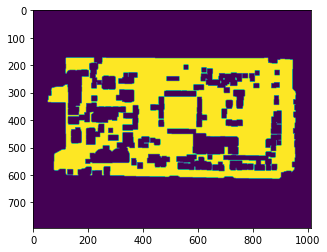

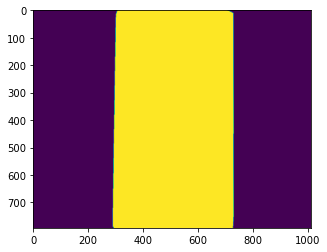

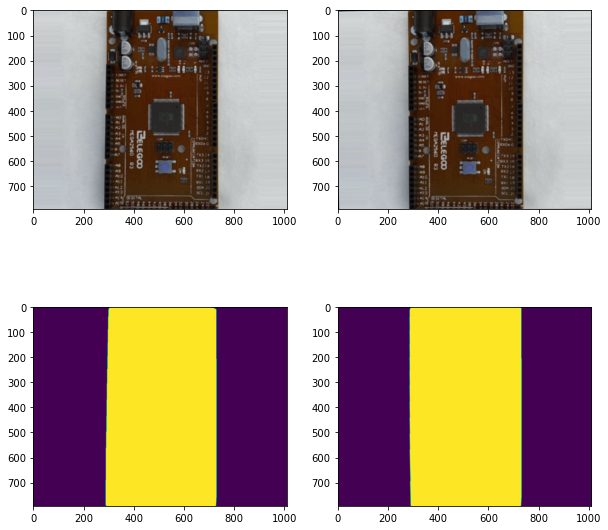

In [163]:
hull,mask = register_imge(test_img_name)

In [142]:
chosen_points = quad_hull_points(hull)

[1390  683]
[  86 1228]
[129 598]
[1293 1247]


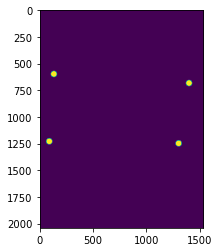

In [143]:
z = np.zeros(mask.shape, dtype=np.uint8)
for point in chosen_points:
    print(point)
    x = point[0]
    y = point[1]
    cv2.circle(z, (x, y), 3, (255, 0, 0), 50)

# drawing skewed rectangle
plt.imshow(z)
plt.show()

In [89]:
chosen_points

array([[1188, 1640],
       [ 523,  384],
       [ 614,  322],
       [1186, 1642]], dtype=int32)

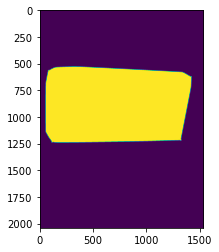

In [619]:
plt.imshow(new_rotated_mask)
plt.show()

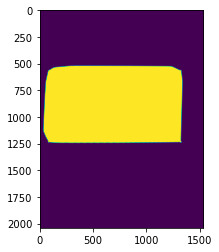

In [620]:
plt.imshow(un_warped)
plt.show()

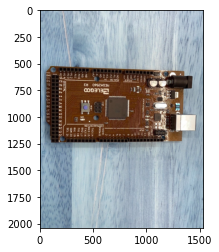

In [622]:
plt.imshow(rotated_image)
plt.show()

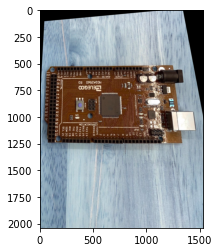

In [623]:
plt.imshow(un_warped)
plt.show()

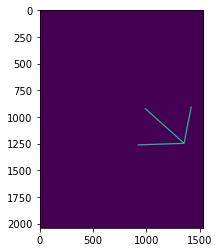

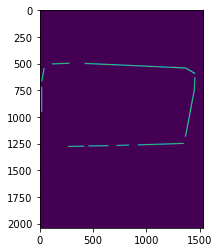

In [356]:
import pandas as pd
def line_detection(input_image):
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 75  # minimum number of pixels making up a line
    max_line_gap = 20  # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(input_image, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
    return lines

import scipy
import scipy.cluster.hierarchy as sch

def compute_neighbor_lines(lines):
    # construct vectors from lines
    all_vecs = []
    for v in lines:
        v = v[0]
        xdir = v[0] - v[2]
        ydir = v[1] - v[3]
        denom = (xdir**2 + ydir**2)**(0.5)
        vec = [xdir/denom,ydir/denom]
        all_vecs.append(vec)
    all_vecs = np.array(all_vecs)

    # create correlation matrix
    A = all_vecs.dot(all_vecs.T)

    # convert 
    df = pd.DataFrame(np.array(A).transpose())

    # cluster
    X = df.corr().values
    d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
    L = sch.linkage(d, method='complete')
    ind = sch.fcluster(L, 0.1*d.max(), 'distance')
    ind_sorted = list((np.argsort(ind)))
    ind = [ind[v] for v in ind_sorted]

    # package results
    line_clusters = {}
    for i in list(set(ind)):
        line_clusters[i] = []
        for num,j in enumerate(ind):
            if i == j:
                line_clusters[i].append(ind_sorted[num])
        
    # illustrate upgrade
    # columns = [df.columns.tolist()[i] for i in ind_sorted]
    # df = df.reindex(columns, axis=1)
    
    # compute largest examples from each cluster
    summary_best = []
    for k in list(line_clusters.keys()):
        # length of line
        line_inds = line_clusters[k]
        container = []
        for i in line_inds:
            v = lines[i][0]
            d = ((v[0] - v[2])**2 + (v[1] - v[3])**2)**0.5
            container.append(d)
        index_max = np.argmax(np.array(container))
        best_choice = line_inds[index_max]
        summary_best.append(best_choice)
        
    # choose lines for return
    best_lines = lines[summary_best]
    best_vecs = all_vecs[summary_best,:]
    
    # if more than 2 clusters formed, find two most orthogonal reps
    if len(best_lines) > 2:
        A = all_vecs[summary_best].dot(all_vecs[summary_best].T)
        keeper_inds = list(np.unravel_index(np.argmin(np.abs(A), axis=None), A.shape))
        best_lines = best_lines[keeper_inds,:,:]
        best_vecs = best_vecs[keeper_inds,:]
        
    if len(best_lines) < 2:
        print('FAILURE: registration process, could not find sufficient data for Affine transformation',flush=True)
        
        
#     ind = [v for v in ind if v <= 2]
#     print(best_lines)
#     np.array(best_lines)
#     all_vecs
    
#     A = np.array(best_lines).dot(np.array(best_lines).T)
#     print(A)
    
    return best_lines


def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return [int(x/z), int(y/z)]


def merge_best_lines(best_lines):
    # compute intersection of best lines
    intersection_point = get_intersect(best_lines[0][0][:2],best_lines[0][0][2:],best_lines[1][0][:2],best_lines[1][0][2:])
    
    # loop through best_lines and select furthers point on each from intersection
    best_lines_2 = []
    for l in best_lines:
        x1 = l[0][0]
        y1 = l[0][1]
        x2 = l[0][2]
        y2 = l[0][3]

        x3 = intersection_point[0]
        y3 = intersection_point[1]

        dist1 = ( (x1-x3)**2 + (y1-y3)**2 )**(0.5)
        dist2 = ( (x2-x3)**2 + (y2-y3)**2 )**(0.5)

        new_best = []
        new_best.append(intersection_point[0])
        new_best.append(intersection_point[1])
        if dist1 > dist2:
            new_best.append(x1)
            new_best.append(y1)
        else:
            new_best.append(x2)
            new_best.append(y2)
        best_lines_2.append(new_best)
                    
    # attach diagonal point
    base_pt = [best_lines_2[0][0], best_lines_2[0][1]]
    pt1 = [best_lines_2[0][2], best_lines_2[0][3]]
    pt2 = [best_lines_2[1][2], best_lines_2[1][3]]
    pt1_dir = [pt1[0] - base_pt[0], pt1[1] - base_pt[1]]
    pt2_dir = [pt2[0] - base_pt[0], pt2[1] - base_pt[1]]
    diag = [pt1_dir[0] + pt2_dir[0],pt1_dir[1] + pt2_dir[1]]
    new_pt = [base_pt[0] + diag[0], base_pt[1] + diag[1]]
    best_lines_2.append(base_pt + new_pt)
    return best_lines_2


lines = line_detection(rotated_binary_convex_hull_gradient)
best_lines = compute_neighbor_lines(lines)
best_lines = merge_best_lines(best_lines)

line_image = np.copy(rotated_gradient) * 0  # creating a blank to draw lines on
for line in best_lines:
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
        
plt.imshow(line_image)
plt.show()

line_image = np.copy(rotated_gradient) * 0  # creating a blank to draw lines on
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
        
plt.imshow(line_image)
plt.show()


starting_pts = []
for num,line in enumerate(best_lines):
    if num == 0:
        pt1 = [line[0],line[1]]
        starting_pts.append(pt1)
    pt2 = [line[2],line[3]]
    starting_pts.append(pt2)

In [357]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

In [358]:
df = pd.DataFrame(np.array(A).transpose())

NameError: name 'A' is not defined

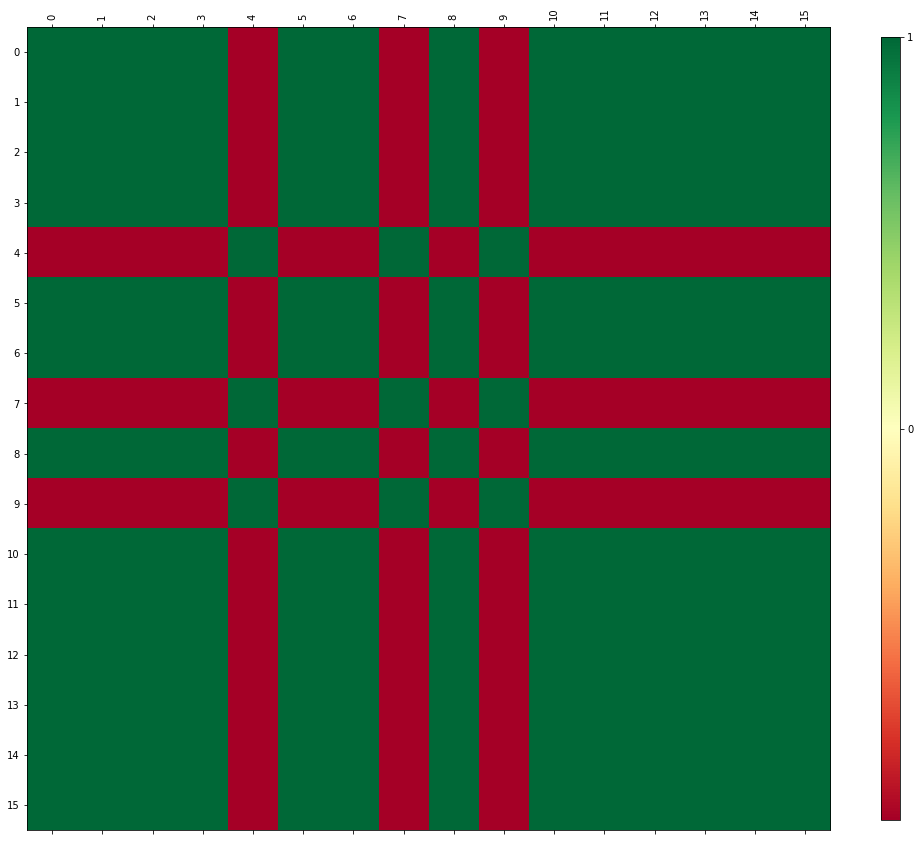

In [1038]:
plot_corr(df, size=18)

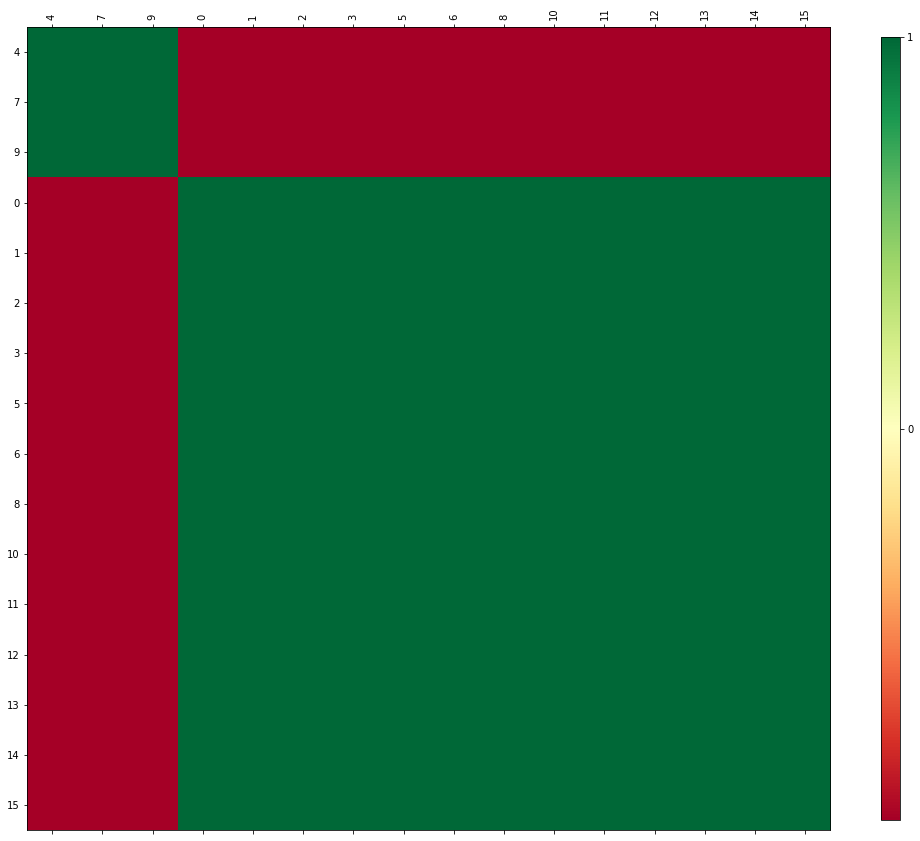

In [1040]:
import scipy
import scipy.cluster.hierarchy as sch

X = df.corr().values
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df = df.reindex(columns, axis=1)

plot_corr(df, size=18)

In [1041]:
columns

[4, 7, 9, 0, 1, 2, 3, 5, 6, 8, 10, 11, 12, 13, 14, 15]

In [ ]:
def find_tightest_quad(input_mask):
    # dialate some more
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(input_mask, kernel, iterations=5)
    
    # compute mask contours
    contours, _ = cv2.findContours(input_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # compute permiter length
    perimeter = cv2.arcLength(contours[0], True)
    
    def compute_approx(p):
        # piecewise linear approx
        approx = cv2.approxPolyDP(contours[0], p * perimeter, True)
        return approx

    # starting prop value
    p_lower = 1
    p_upper = 0
    p_lower_prev = -1
    approx_lower = compute_approx(p_lower)
    num_lower = len(approx_lower)
    num_upper = 100

    # bisect for tighter 4 sided poly
    max_count = 10
    count = 1
    num_temp = 1

    # perform bisection rounds to tighten up lower
    while count <= max_count:
        if num_lower <= 4 and num_upper >= 4:
            # try cutting in half
            p_temp = (p_lower - p_upper)/2 + p_upper
            approx_temp = compute_approx(p_temp)
            num_temp = len(approx_temp)

            # update bounds
            if num_temp <= 4: # move up lower bound
                approx_lower = approx_temp
                num_lower = num_temp
                p_lower_prev = p_lower
                p_lower = p_temp
            else:
                approx_upper = approx_temp
                num_upper = num_temp
                p_upper = p_temp

            count+=1

    # keep lowers
    p = p_lower
    approx = approx_lower
    return approx

# illustrate tightest quad
def illustrate_tightest_quad(input_mask,quad_approx):
    # illustrate tightest quad
    mask = np.zeros(input_mask.shape, dtype=np.uint8)
    for point in quad_approx:
        x, y = point[0]
        cv2.circle(mask, (x, y), 3, (0, 255, 0), 5)

    # drawing skewed rectangle
    cv2.drawContours(mask, [quad_approx], -1, (0, 255, 0),5);
    plt.imshow(mask)
    plt.show()
    return mask

# compute tightest quad approx to mask
quad_approx = find_tightest_quad(rotated_binary_convex_hull)

In [997]:
line_image_2 = np.copy(line_image) * 0  
dst = cv2.cornerHarris(line_image,2,3,0.04)
line_image_2[dst>0.01*dst.max()]=255

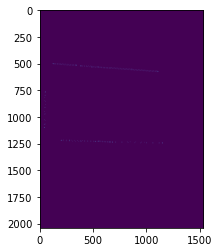

In [999]:
plt.imshow(line_image_2)
plt.show()

In [888]:
# Taking a matrix of size 5 as the kernel


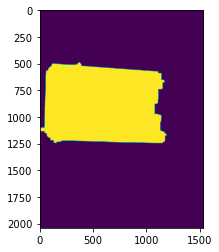

In [889]:
plt.imshow(img_erosion)
plt.show()

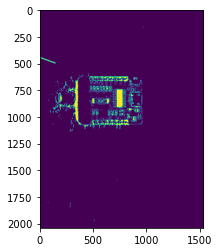

In [809]:
lower_color_bound = np.array((25,25,25),dtype=np.uint8, ndmin=1)
upper_color_bound = np.array((100,100,100),dtype=np.uint8, ndmin=1)

mask = cv2.inRange(rotated_image,lower_color_bound,upper_color_bound)


plt.imshow(mask)
plt.show()

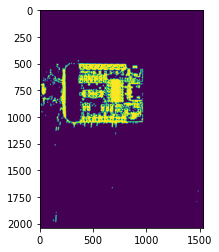

In [742]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# draw contours and hull points
for i in range(len(contours)):
    color_contours = (255, 255, 255) # green - color for contours

    # draw ith contour
    cv2.drawContours(mask, contours, i, color_contours, 5, 8, hierarchy)
    
plt.imshow(mask)
plt.show()

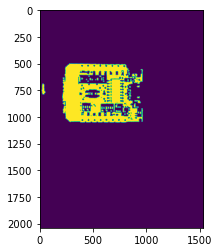

In [744]:
plt.imshow(rotated_binary)
plt.show()

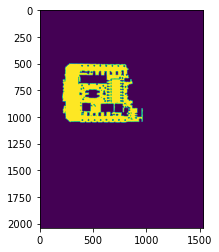

In [756]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

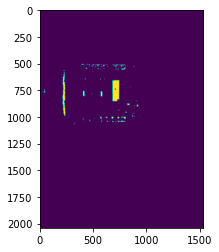

In [736]:
# erode to reomve spots
kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel,iterations=2) 

plt.imshow(mask)
plt.show()

In [658]:
contours, hierarchy = cv2.findContours(rotated_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [659]:
# # create hull array for convex hull points
# hull = []

# # calculate points for each contour
# for i in range(len(contours)):
#     # creating convex hull object for each contour
#     hull.append(cv2.convexHull(contours[i], False))

In [660]:
# # draw contours and hull points
# for i in range(len(contours)):
#     color_contours = (0, 255, 0) # green - color for contours
#     color = (255, 0, 0) # blue - color for convex hull

#     # draw ith contour
#     # cv2.drawContours(rotated_binary, contours, i, color_contours, 5, 8, hierarchy)

#     # draw ith convex hull object
#     cv2.drawContours(rotated_image, hull, i, color, 5, 8)

In [671]:
hull = cv2.convexHull(cnt,returnPoints = False)

drawing = np.zeros((rotated_image.shape[0], rotated_image.shape[1], 3), np.uint8)


In [669]:
color = (255, 0, 0)
rotated_image = cv2.drawContours(rotated_image,[hull],0,(0,0,255),2)

error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/drawing.cpp:2502: error: (-215:Assertion failed) npoints > 0 in function 'drawContours'


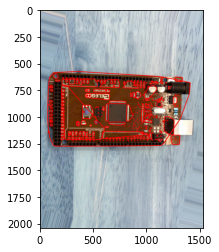

In [668]:
plt.imshow(rotated_image)
plt.show()

In [544]:
contours,_ = cv2.findContours(rotated_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) != 0:
    # draw in blue the contours that were founded
    # cv2.drawContours(rotated_image, contours, -1, 255, 3)

    # find the biggest countour (c) by the area
    c = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)

    # draw the biggest contour (c) in green
    cv2.rectangle(rotated_image,(x,y),(x+w,y+h),(0,255,0),2)

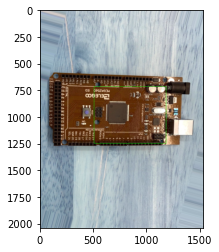

In [545]:
plt.imshow(rotated_image)
plt.show()

In [522]:
hull = cv2.convexHull(contours[0])

In [525]:
image=cv2.drawContours(image,[hull],0,(0,0,255),2)

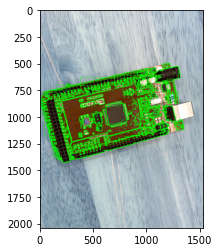

In [526]:
plt.imshow(image)
plt.show()

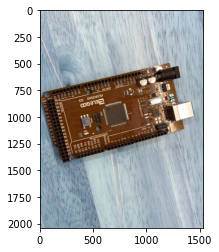

In [476]:
image = cv2.imread(test_img_name)
cnt = contours[0]
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(image,[box],0,(0,0,255),2)

plt.imshow(image)
plt.show()

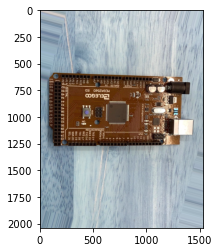

In [514]:
plt.imshow(rotated_image)
plt.show()

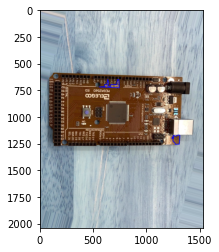

In [515]:

# Detecting shapes in image by selecting region 
# with same colors or intensity.
contours,_ = cv2.findContours(rotated_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Searching through every region selected to 
# find the required polygon.
for cnt in contours :
    area = cv2.contourArea(cnt)
   
    # Shortlisting the regions based on there area.
    if area > 4000 and area < 5000: 
        approx = cv2.approxPolyDP(cnt, 
                                  0.009 * cv2.arcLength(cnt, True), True)
   
        # Checking if the no. of sides of the selected region is 7.
        # if(len(approx) == 4): 
        cv2.drawContours(rotated_image, [approx], 0, (0, 0, 255), 5)
        
plt.imshow(rotated_image)
plt.show()

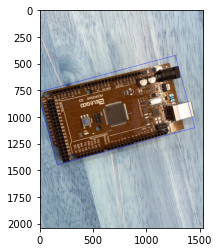

In [396]:
rect = cv2.minAreaRect(coords)
box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
box = np.int0(box)

ya = cv2.drawContours(image,[box[:,[1,0]]],0,(0,0,255),2)
plt.imshow(ya)
plt.show()

In [450]:
dst = cv2.cornerHarris(rotated_binary,2,3,0.04)
rotated_image[dst>0.01*dst.max()]=[0,255,0]

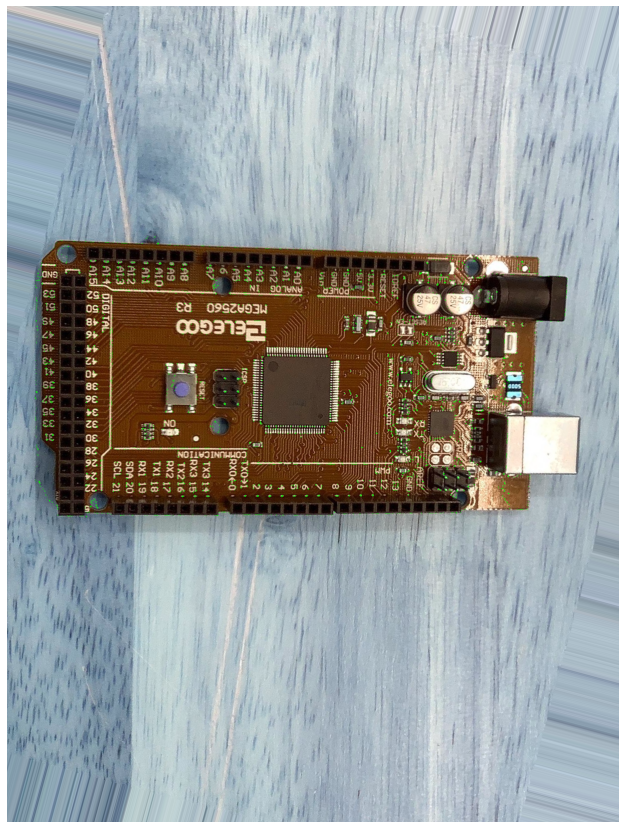

In [451]:
fig, axes = plt.subplots(ncols=3, figsize=(15,15))
ax = axes.ravel()
ax[0] = plt.subplot(1, 1, 1)
ax[0].imshow(rotated_image)
ax[0].axis('off')
plt.show()


The corner points are...

A : [115, 1050]
B : [658, 1224]
C : [852, 659]
D : [1097, 784]


Text(0.5, 1.0, 'Corner Detection: Shi-Tomashi')

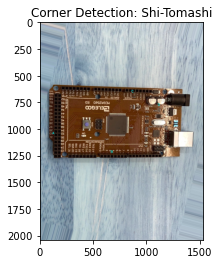

In [458]:
corners = cv2.goodFeaturesToTrack(rotated_binary, 4, 0.01, 100)
corners = np.int0(corners)
corners = sorted(np.concatenate(corners).tolist())
print('\nThe corner points are...\n')

im = image.copy()
for index, c in enumerate(corners):
    x, y = c
    cv2.circle(rotated_image, (x, y), 3, 255, -1)
    character = chr(65 + index)
    print(character, ':', c)
    cv2.putText(rotated_image, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

plt.imshow(rotated_image)
plt.title('Corner Detection: Shi-Tomashi')

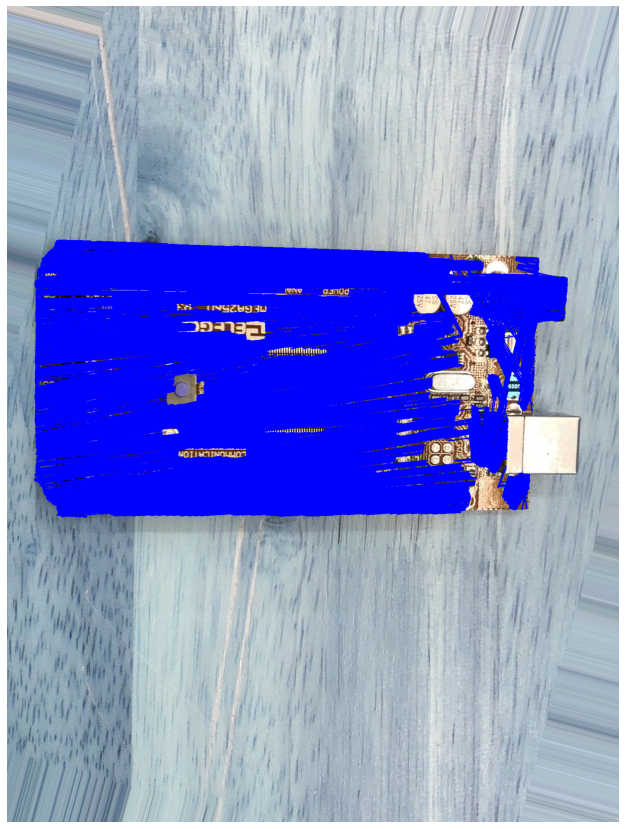

In [454]:
fig, axes = plt.subplots(ncols=3, figsize=(15,15))
ax = axes.ravel()
ax[0] = plt.subplot(1, 1, 1)
ax[0].imshow(rotated_image)
ax[0].axis('off')
plt.show()

In [336]:
# find bounding box of processed threshold image
x_axis = np.max(binary,axis=0)
y_axis = np.max(binary,axis=1)

ind = np.argwhere(x_axis == 255)
ind = [v[0] for v in ind]
x_first = ind[0]
x_last = ind[-1]

ind = np.argwhere(y_axis == 255)
ind = [v[0] for v in ind][::-1]
y_first = ind[0]
y_last = ind[-1]

x = x_first
y = y_first
w = x_last - x_first
h = y_first - y_last 
print(x,x+h,y,y-h)

# cut out this portion of image
test_img = cv2.imread(test_img_name)
# test_img = test_img[x:x+w, y:y-h,:]

7 939 1429 497


In [337]:
test=np.asarray(test_img)


In [329]:
test.shape

(2040, 1530, 3)